# Timeseries Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import multiprocessing as mp
import dill
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

In [1266]:
df_market_estimates = pd.read_pickle('df_market.pkl')
df_market_predictions = pd.read_pickle('df_market_predictions.pkl')

In [6]:
df_market = pd.read_pickle('df_market.pkl')

## Prediction Evaluation

### Histograms of model predictions

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


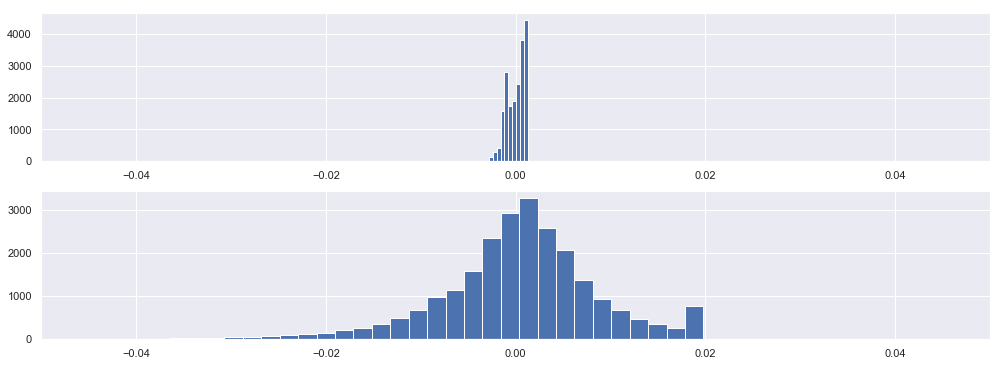

In [1049]:
fig, ax = plt.subplots(2,1, figsize=[17,6])
ax[0].set_xlim([-0.05,0.05])
ax[0].hist(df_market_predictions[(1,'mean')], bins=10)
ax[1].set_xlim([-0.05,0.05])
ax[1].hist(df_market_predictions[('data','return')], bins=100)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


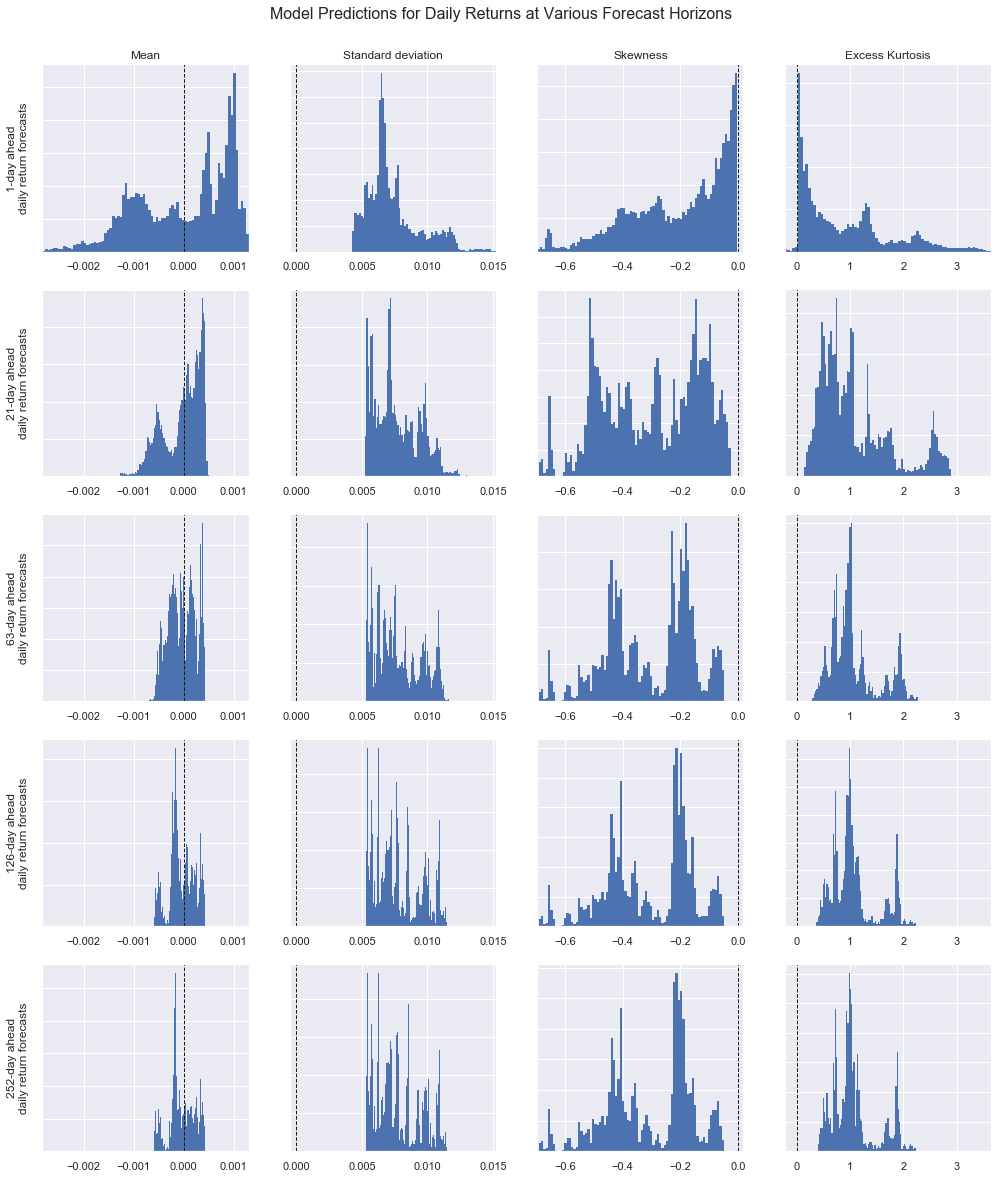

In [1083]:
horizons = [1,21,63,126,252]

fig, axes = plt.subplots(len(horizons), 4, figsize=(17,20))

row = 0
for h in horizons:
    
    axes[row,0].set_xlim([df_market_predictions[(1,'mean')].min(), df_market_predictions[(1,'mean')].max()])
    axes[row,0].hist(df_market_predictions[(h,'mean')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,0].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,0].set_yticklabels([])
    
    axes[row,1].set_xlim([-0.0005, df_market_predictions[(1,'std')].max()])
    axes[row,1].hist(df_market_predictions[(h,'std')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,1].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,1].set_yticklabels([])
    
    axes[row,2].set_xlim([df_market_predictions[(1,'skew')].min(), 0.02])
    axes[row,2].hist(df_market_predictions[(h,'skew')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,2].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,2].set_yticklabels([])
    
    axes[row,3].set_xlim([df_market_predictions[(1,'kurt')].min(), df_market_predictions[(1,'kurt')].max()])
    axes[row,3].hist(df_market_predictions[(h,'kurt')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,3].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,3].set_yticklabels([])
    
    #axes[row,4].set_xlim([0, 1])
    #axes[row,4].hist(df_market_predictions[(h,'entropy')], bins=80, histtype='stepfilled', linewidth=0)
    #axes[row,4].axvline(0, color='k', linestyle='--', linewidth=1)
    #axes[row,4].set_yticklabels([])
    
    axes[row,0].set_ylabel(str(h)+'-day ahead\ndaily return forecasts')

    row += 1

axes[0,0].set_title('Mean')
axes[0,1].set_title('Standard deviation')
axes[0,2].set_title('Skewness')
axes[0,3].set_title('Excess Kurtosis')
#axes[0,4].set_title('Entropy')

fig.suptitle('Model Predictions for Daily Returns at Various Forecast Horizons', y=0.92, fontsize=16)
    
plt.show()

fig.savefig('onePeriodPredictionsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


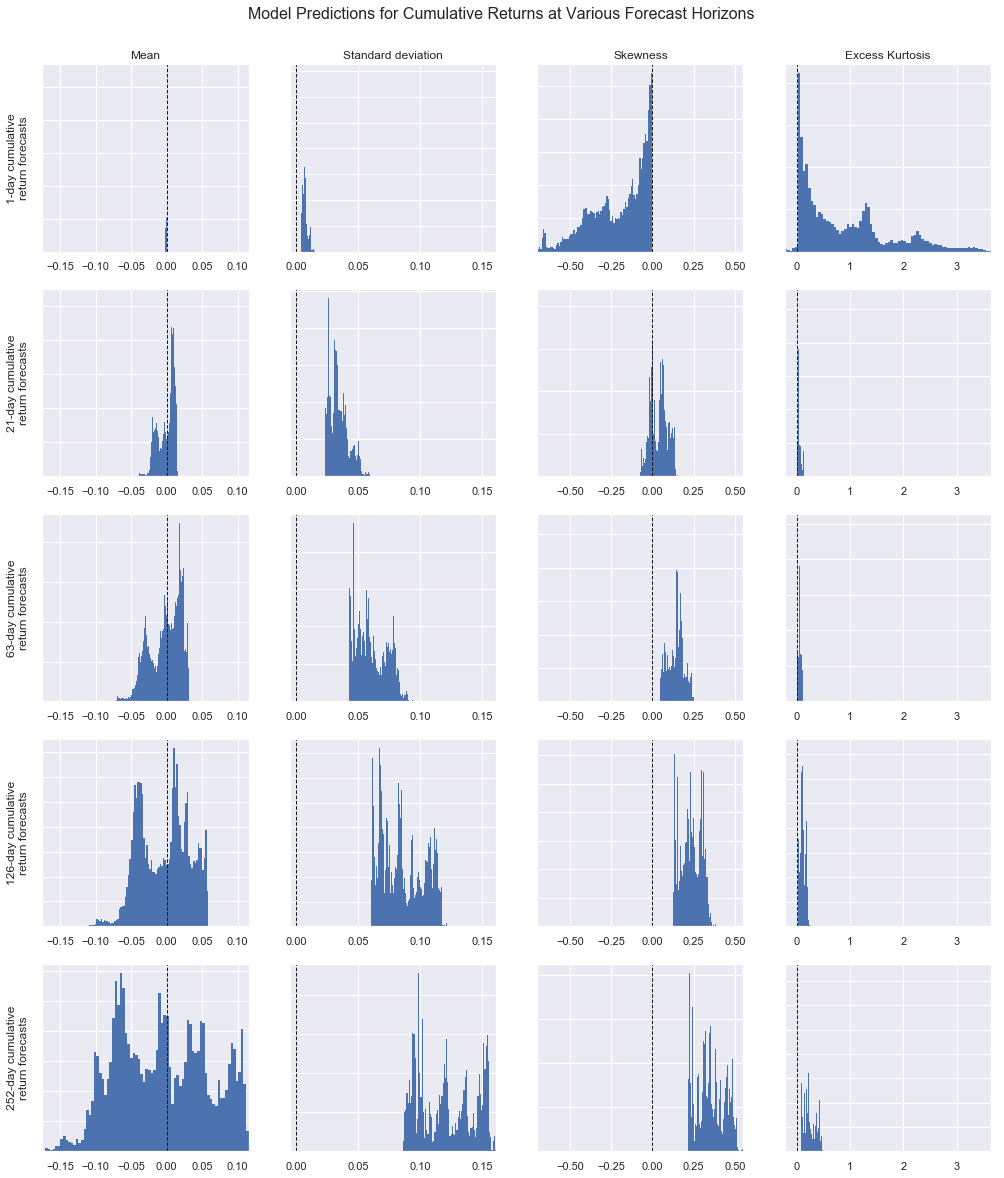

In [1078]:
horizons = [1,21,63,126,252]

fig, axes = plt.subplots(len(horizons), 4, figsize=(17,20))

row = 0
for h in horizons:
    
    axes[row,0].set_xlim([df_market_predictions[(252,'cummean')].min(), df_market_predictions[(252,'cummean')].max()])
    axes[row,0].hist(df_market_predictions[(h,'cummean')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,0].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,0].set_yticklabels([])
    
    axes[row,1].set_xlim([-0.005, df_market_predictions[(252,'cumvar')].max()**0.5])
    axes[row,1].hist(df_market_predictions[(h,'cumvar')]**0.5, bins=80, histtype='stepfilled', linewidth=0)
    axes[row,1].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,1].set_yticklabels([])
    
    axes[row,2].set_xlim([df_market_predictions[(1,'cumskew')].min(), df_market_predictions[(252,'cumskew')].max()])
    axes[row,2].hist(df_market_predictions[(h,'cumskew')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,2].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,2].set_yticklabels([])
    
    axes[row,3].set_xlim([df_market_predictions[(1,'cumkurt')].min(), df_market_predictions[(1,'cumkurt')].max()])
    axes[row,3].hist(df_market_predictions[(h,'cumkurt')], bins=80, histtype='stepfilled', linewidth=0)
    axes[row,3].axvline(0, color='k', linestyle='--', linewidth=1)
    axes[row,3].set_yticklabels([])
    
    axes[row,0].set_ylabel(str(h)+'-day cumulative\nreturn forecasts')

    row += 1
    
axes[0,0].set_title('Mean')
axes[0,1].set_title('Standard deviation')
axes[0,2].set_title('Skewness')
axes[0,3].set_title('Excess Kurtosis')

fig.suptitle('Model Predictions for Cumulative Returns at Various Forecast Horizons', y=0.92, fontsize=16)
    
plt.show()

fig.savefig('cumulativePredictionsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

### Predictive Regressions

#### Means: 1-period

In [1095]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='mean']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','mean'],['est','s.e.','s.e. hac']]))
clip = 0.975
for h in horizons:
    y = df_market_predictions[('data','return')]
    #y = y.clip(upper=y.quantile(clip))
    x = sm.add_constant(df_market_predictions[[(h,'mean')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','mean'],'est')] = reg.params.values
    df_regs.loc[h,(['const','mean'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','mean'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

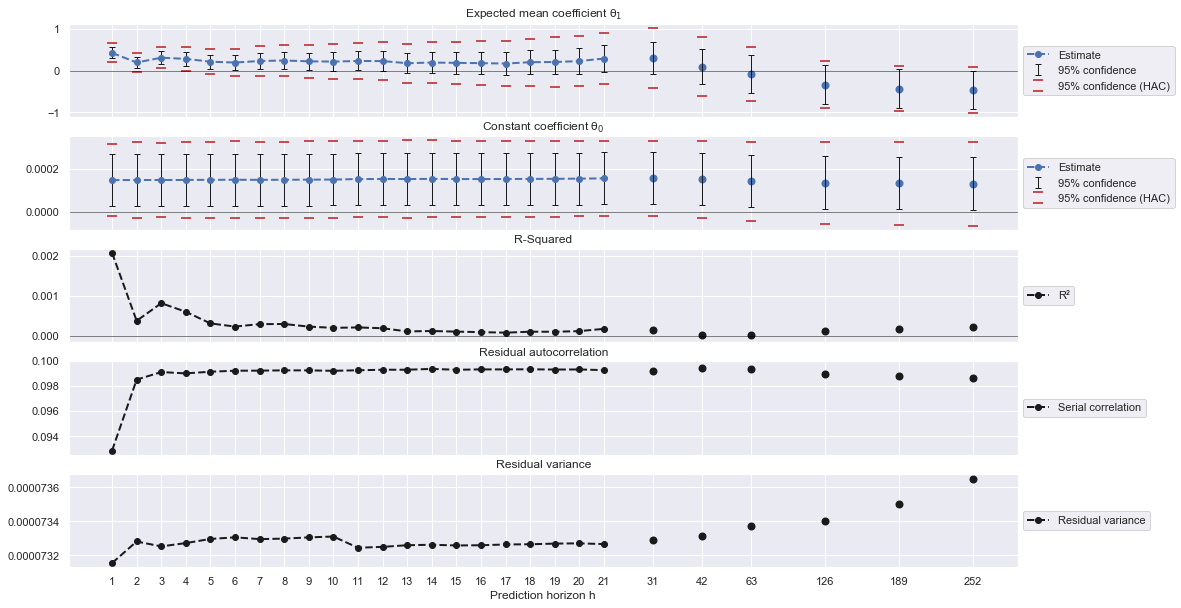

In [1096]:
fig, axes = plt.subplots(5, 1, figsize=(17,10))

axes[0].plot(horizons[0:21], df_regs['mean','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['mean','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels([])
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Expected mean coefficient θ$_1$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels([])
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Constant coefficient θ$_0$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels([])
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[3].plot(horizons[0:21], df_regs['regression','resid_autocorr'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Serial correlation')
axes[3].scatter([23,25,27,30,33,36], df_regs['regression','resid_autocorr'].values[21:], linewidth=2, marker='o', color='k')
axes[3].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[3].set_xticklabels([])
axes[3].set_title('Residual autocorrelation')
axes[3].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[4].plot(horizons[0:21], df_regs['regression','resid_var'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Residual variance')
axes[4].scatter([23,25,27,30,33,36], df_regs['regression','resid_var'].values[21:], linewidth=2, marker='o', color='k')
axes[4].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[4].set_xticklabels(horizons)
axes[4].set_xlabel('Prediction horizon h')
axes[4].set_title('Residual variance')
axes[4].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

plt.show()

fig.savefig('onePeriodMeanPredictabilityPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

#### Variance: 1-period

In [1259]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='var']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','var'],['est','s.e.','s.e. hac']]))
clip = 0.98
for h in horizons:
    y = ((df_market_predictions[('data','return')]-df_market_predictions[(h,'mean')].shift(h))**2)**0.5
    #y = y.clip(upper=y.quantile(clip))
    x = sm.add_constant(df_market_predictions[[(h,'std')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','var'],'est')] = reg.params.values
    df_regs.loc[h,(['const','var'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','var'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

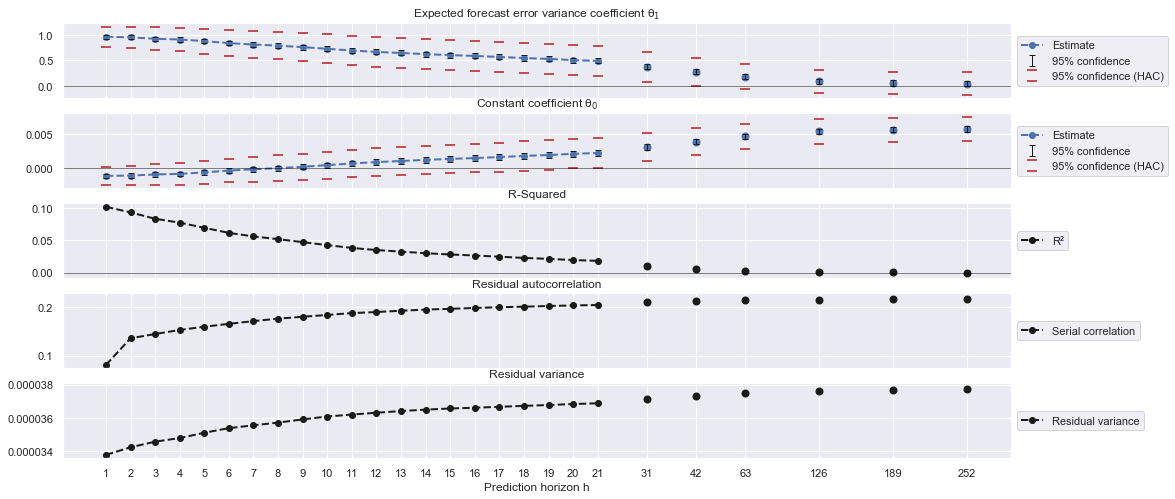

In [1260]:
fig, axes = plt.subplots(5, 1, figsize=(17,8))

axes[0].plot(horizons[0:21], df_regs['var','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['var','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels([])
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['var','est'].values, yerr=df_regs['var','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['var','est'].values, yerr=df_regs['var','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Expected forecast error coefficient θ$_1$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels([])
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Constant coefficient θ$_0$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels([])
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[3].plot(horizons[0:21], df_regs['regression','resid_autocorr'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Serial correlation')
axes[3].scatter([23,25,27,30,33,36], df_regs['regression','resid_autocorr'].values[21:], linewidth=2, marker='o', color='k')
axes[3].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[3].set_xticklabels([])
axes[3].set_title('Residual autocorrelation')
axes[3].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[4].plot(horizons[0:21], df_regs['regression','resid_var'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Residual variance')
axes[4].scatter([23,25,27,30,33,36], df_regs['regression','resid_var'].values[21:], linewidth=2, marker='o', color='k')
axes[4].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[4].set_xticklabels(horizons)
axes[4].set_xlabel('Prediction horizon h')
axes[4].set_title('Residual variance')
axes[4].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

plt.show()

fig.savefig('onePeriodVariancePredictabilityPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

#### Means: Cumulative

In [1113]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='mean']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','cummean'],['est','s.e.','s.e. hac']]))
clip = 0.975
for h in horizons:
    y = (1+df_market_estimates[('raw_data','return')]).rolling(window=h).apply(np.prod, raw=True).shift(-h+1) - 1
    y = y.clip(upper=y.quantile(clip))
    x = sm.add_constant(df_market_predictions[[(h,'cummean')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','cummean'],'est')] = reg.params.values
    df_regs.loc[h,(['const','cummean'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','cummean'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

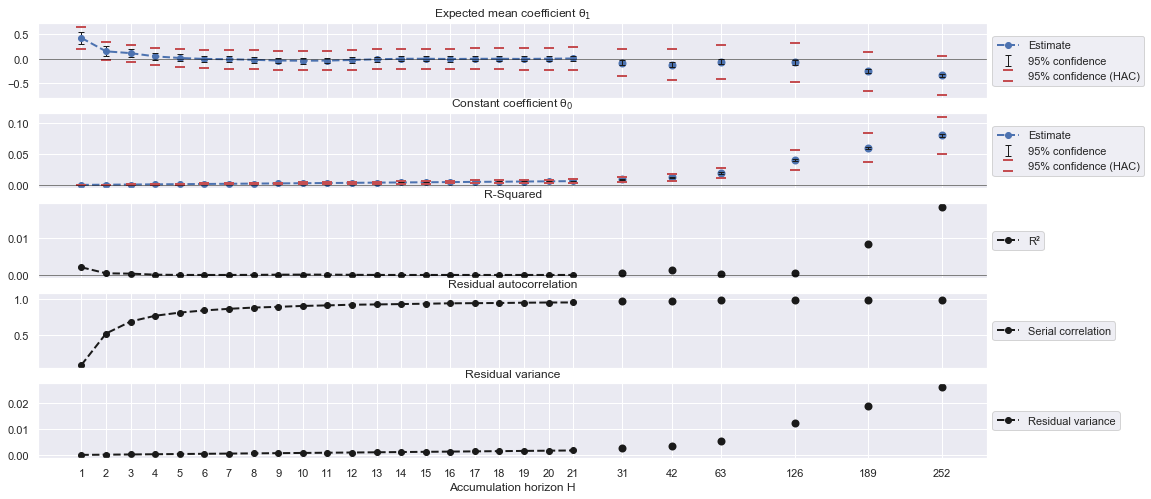

In [1114]:
fig, axes = plt.subplots(5, 1, figsize=(17,8))

axes[0].plot(horizons[0:21], df_regs['cummean','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['cummean','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels([])
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['cummean','est'].values, yerr=df_regs['cummean','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['cummean','est'].values, yerr=df_regs['cummean','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Expected mean coefficient θ$_1$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels([])
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Constant coefficient θ$_0$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels([])
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[3].plot(horizons[0:21], df_regs['regression','resid_autocorr'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Serial correlation')
axes[3].scatter([23,25,27,30,33,36], df_regs['regression','resid_autocorr'].values[21:], linewidth=2, marker='o', color='k')
axes[3].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[3].set_xticklabels([])
axes[3].set_title('Residual autocorrelation')
axes[3].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[4].plot(horizons[0:21], df_regs['regression','resid_var'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Residual variance')
axes[4].scatter([23,25,27,30,33,36], df_regs['regression','resid_var'].values[21:], linewidth=2, marker='o', color='k')
axes[4].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[4].set_xticklabels(horizons)
axes[4].set_xlabel('Accumulation horizon H')
axes[4].set_title('Residual variance')
axes[4].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

plt.show()

fig.savefig('cumulativeMeanPredictabilityPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

#### Variance: Cumulative

In [1269]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='mean']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','cumvar'],['est','s.e.','s.e. hac']]))
clip = 0.98
for h in horizons:#[horizons>1]:
    cret = (1+df_market_estimates[('raw_data','return')]).rolling(window=h).apply(np.prod, raw=True).shift(-h+1) - 1
    y = ((cret-df_market_predictions[(h,'cummean')].shift(h))**2)**0.5
    #y = y.clip(upper=y.quantile(clip))
    #y = (df_market_estimates[('raw_data','return')]).rolling(window=h).var().shift(-h+1)*h
    x = sm.add_constant(df_market_predictions[[(h,'cumstd')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','cumvar'],'est')] = reg.params.values
    df_regs.loc[h,(['const','cumvar'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','cumvar'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

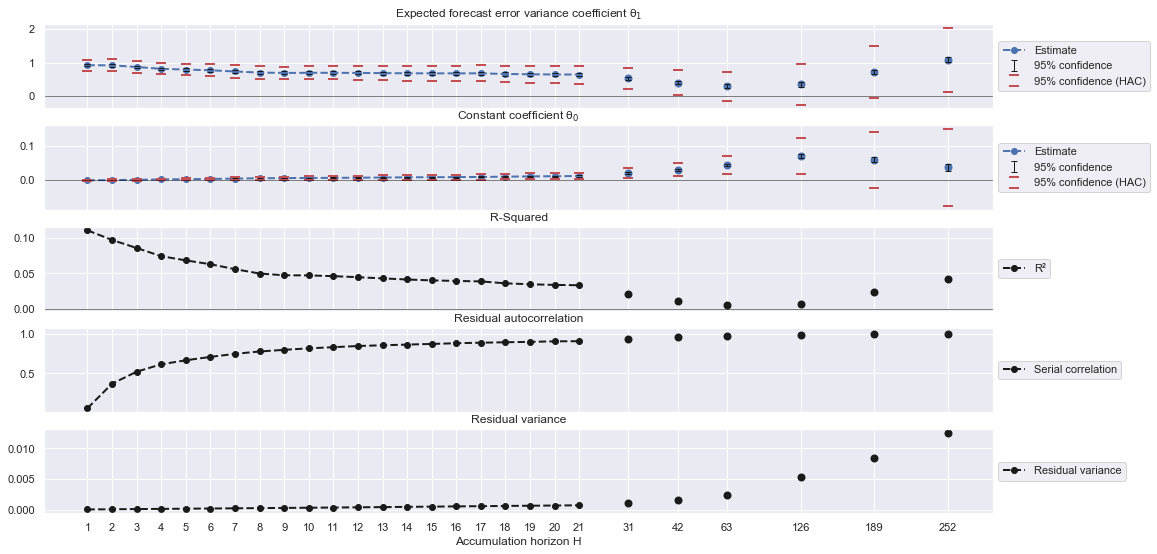

In [1270]:
fig, axes = plt.subplots(5, 1, figsize=(17,9))

axes[0].plot(horizons[0:21], df_regs['cumvar','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['cumvar','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels([])
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['cumvar','est'].values, yerr=df_regs['cumvar','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['cumvar','est'].values, yerr=df_regs['cumvar','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Expected forecast error coefficient θ$_1$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels([])
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Constant coefficient θ$_0$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels([])
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[3].plot(horizons[0:21], df_regs['regression','resid_autocorr'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Serial correlation')
axes[3].scatter([23,25,27,30,33,36], df_regs['regression','resid_autocorr'].values[21:], linewidth=2, marker='o', color='k')
axes[3].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[3].set_xticklabels([])
axes[3].set_title('Residual autocorrelation')
axes[3].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[4].plot(horizons[0:21], df_regs['regression','resid_var'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='Residual variance')
axes[4].scatter([23,25,27,30,33,36], df_regs['regression','resid_var'].values[21:], linewidth=2, marker='o', color='k')
axes[4].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[4].set_xticklabels(horizons)
axes[4].set_xlabel('Accumulation horizon H')
axes[4].set_title('Residual variance')
axes[4].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

plt.show()

fig.savefig('cumulativeVariancePredictabilityPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

### Simple trading strategies

#### Construct

In [1127]:
include = df_market_predictions.index[df_market_predictions[1,'mean'].notna()]

In [1194]:
# long market
s0 = df_market_estimates['raw_data','return'][include]

# long if mean positively predicted
s1 = df_market_estimates['raw_data','return'][include]*((df_market_predictions[1,'mean'][include]).shift(1)>0).replace(False,0)

# volatility targeting
target = 0.10/np.sqrt(252)
s2 = df_market_estimates['raw_data','return'][include]/((df_market_predictions[1,'std'][include]/target).shift(1))

# combination
s3 = s1/((df_market_predictions[1,'std'][include]/target).shift(1))

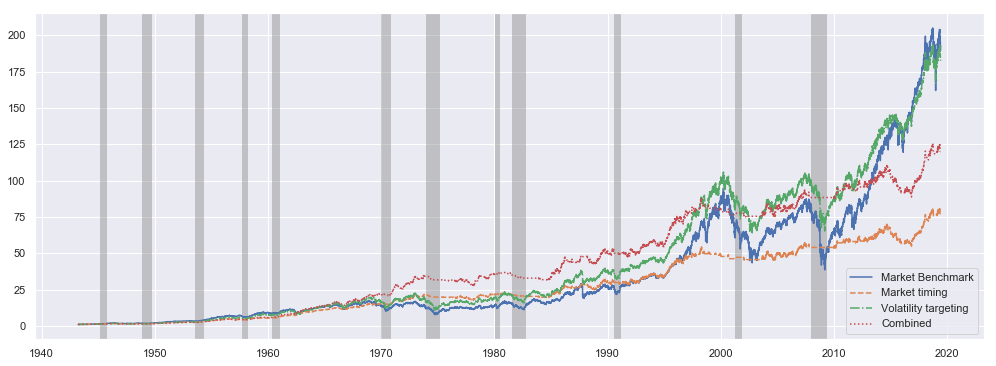

In [1257]:
fig,ax = plt.subplots(1,1,figsize=[17,6])

plot.add_recession_bars(ax, startdate=include[0])
ax.plot((1+s0).cumprod(), label='Market Benchmark', linestyle='-', rasterized=True)
ax.plot((1+s1).cumprod(), label='Market timing', linestyle='--', rasterized=True)
ax.plot((1+s2).cumprod(), label='Volatility targeting', linestyle='-.', rasterized=True)
ax.plot((1+s3).cumprod(), label='Combined', linestyle=':', rasterized=True)

ax.legend()

plt.show()

fig.savefig('marketStrategiesPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [1214]:
df_strategies = pd.DataFrame({'Market':s0,'timing':s1, 'vola':s2, 'combined':s3})

In [1273]:
performance_table = pd.DataFrame(columns=['Market benchmark','Market timing','Volatility targeting','Combined'])

performance_table.loc['Annual return'] = df_strategies.mean().values*252
performance_table.loc['Annual volatility'] = df_strategies.std().values*np.sqrt(252)
performance_table.loc['Sharpe ratio'] = performance_table.loc['Annual return']/performance_table.loc['Annual volatility']
performance_table.loc['Losing days $\%$'] = ((df_strategies<0).sum()/df_strategies.count()).values
performance_table.loc['Daily VaR 95 $\%$'] = df_strategies.quantile(0.05).values
performance_table.loc['Daily VaR 99 $\%$'] = df_strategies.quantile(0.01).values
performance_table.loc['Max Drawdown'] = ((1+df_strategies).cumprod()/(1+df_strategies).cumprod().cummax()-1).min().values

calc.export_df_to_latex(performance_table, 'performance_table')

performance_table

,Market benchmark,Market timing,Volatility targeting,Combined
Annual return,0.0784,0.0588,0.0739,0.0646
Annual volatility,0.1449,0.0719,0.1146,0.0732
Sharpe ratio,0.5406,0.8175,0.6450,0.8823
Losing days $\%$,0.4512,0.2387,0.4513,0.2387
Daily VaR 95 $\%$,-0.0141,-0.0073,-0.0117,-0.0075
Daily VaR 99 $\%$,-0.0254,-0.0145,-0.0190,-0.0144
Max Drawdown,-0.5928,-0.2171,-0.5150,-0.2110


## Other Tests (OLD CODE)

### Skewness

In [758]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='skew']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','skew'],['est','s.e.','s.e. hac']]))
for h in horizons:
    y = ((df_market_predictions[('data','return')]-df_market_predictions[(h,'mean')].shift(h))/(df_market_predictions[(h,'var')].shift(h))**0.5)**3
    x = sm.add_constant(df_market_predictions[[(h,'skew')]].shift(h))
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','skew'],'est')] = reg.params.values
    df_regs.loc[h,(['const','skew'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','skew'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse

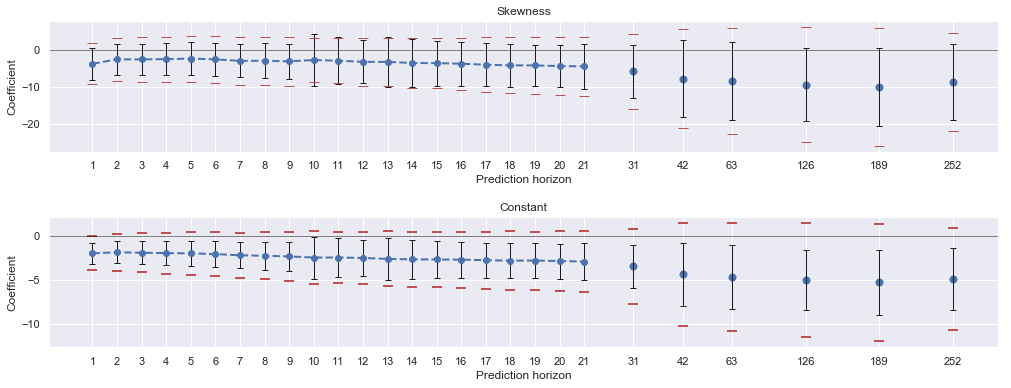

In [759]:
fig, axes = plt.subplots(2, 1, figsize=(17,6))

axes[0].plot(horizons[0:21], df_regs['skew','est'].values[0:21], linewidth=2, label='Skew', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['skew','est'].values[21:], linewidth=2, label='Skew', marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels(horizons)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['skew','est'].values, yerr=df_regs['skew','s.e.'].values*1.96, fmt='none', color='k', linewidth=1, capsize=3)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['skew','est'].values, yerr=df_regs['skew','s.e. hac'].values*1.96, fmt='none', color='r', linewidth=0, capsize=5)
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_xlabel('Prediction horizon')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Skewness')

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Const', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, label='Const', marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels(horizons)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, fmt='none', color='k', linewidth=1, capsize=3)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2)
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_xlabel('Prediction horizon')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Constant')

plt.subplots_adjust(hspace=0.5)

plt.show()

### Kurtosis

In [760]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='kurt']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','kurt'],['est','s.e.','s.e. hac']]))
for h in horizons:
    #y = df_market_predictions[('data','return4')]
    y = ((df_market_predictions[('data','return')]-df_market_predictions[(h,'mean')].shift(h))/(df_market_predictions[(h,'var')].shift(h))**0.5)**4
    y[y>y.quantile(0.99)] = np.nan
    x = sm.add_constant(df_market_predictions[[(h,'kurt')]].shift(h))
    #x = df_market_predictions[[(h,'kurt')]].shift(h)
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','kurt'],'est')] = reg.params.values
    df_regs.loc[h,(['const','kurt'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','kurt'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    
    #df_regs.loc[h,(['kurt'],'est')] = reg.params.values
    #df_regs.loc[h,(['kurt'],'s.e.')] = reg.bse.values
    #df_regs.loc[h,(['kurt'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse

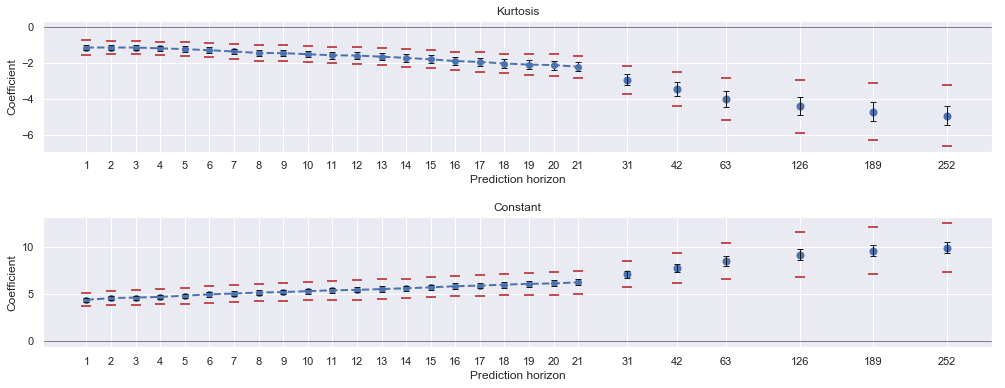

In [761]:
fig, axes = plt.subplots(2, 1, figsize=(17,6))

axes[0].plot(horizons[0:21], df_regs['kurt','est'].values[0:21], linewidth=2, label='Kurt', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['kurt','est'].values[21:], linewidth=2, label='Kurt', marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels(horizons)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['kurt','est'].values, yerr=df_regs['kurt','s.e.'].values*1.96, fmt='none', color='k', linewidth=1, capsize=3)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['kurt','est'].values, yerr=df_regs['kurt','s.e. hac'].values*1.96, fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2)
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_xlabel('Prediction horizon')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Kurtosis')

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Const', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, label='Const', marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels(horizons)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, fmt='none', color='k', linewidth=1, capsize=3)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2)
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_xlabel('Prediction horizon')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Constant')

plt.subplots_adjust(hspace=0.5)

plt.show()

#### Skewness: Cumulative

In [939]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='mean']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','mean'],['est','s.e.','s.e. hac']]))
clip = 0.975
for h in horizons[horizons>2]:
    #cret = (1+df_market_estimates[('raw_data','return')]).rolling(window=h).apply(np.prod, raw=True).shift(-h+1) - 1
    #y = (cret-df_market_predictions[(h,'cummean')].shift(h))**2
    #y = y.clip(upper=y.quantile(clip))
    y = (df_market_estimates[('raw_data','return')]).rolling(window=h).skew().shift(-h+1)
    x = sm.add_constant(df_market_predictions[[(h,'cumskew')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','mean'],'est')] = reg.params.values
    df_regs.loc[h,(['const','mean'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','mean'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

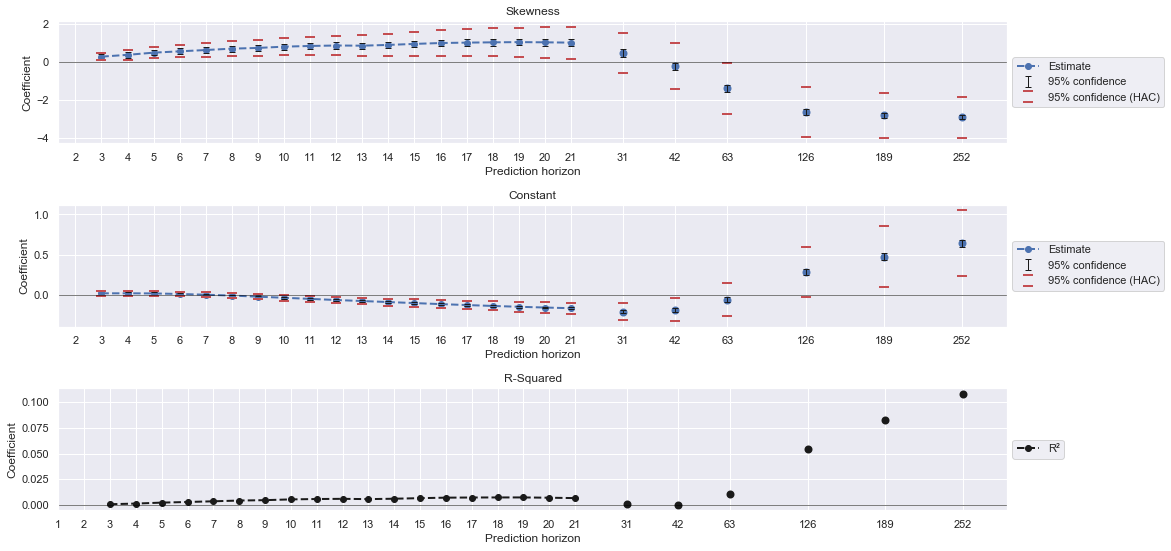

In [940]:
fig, axes = plt.subplots(3, 1, figsize=(17,9))

axes[0].plot(horizons[0:21], df_regs['mean','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['mean','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels(horizons)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_xlabel('Prediction horizon')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Skewness')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels(horizons)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_xlabel('Prediction horizon')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Constant')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels(horizons)
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_xlabel('Prediction horizon')
axes[2].set_ylabel('Coefficient')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.5)

plt.show()

#### Kurtosis: Cumulative

In [978]:
horizons = df_market_predictions.columns.get_level_values(0)[df_market_predictions.columns.get_level_values(1)=='mean']
df_regs = pd.DataFrame(index=horizons, columns=pd.MultiIndex.from_product([['const','mean'],['est','s.e.','s.e. hac']]))
clip = 0.975
for h in horizons[horizons>3]:
    cret = (1+df_market_estimates[('raw_data','return')]).rolling(window=h).apply(np.prod, raw=True).shift(-h+1) - 1
    #y = (cret-df_market_predictions[(h,'cummean')].shift(h))**2
    #y = y.clip(upper=y.quantile(clip))
    y = (df_market_estimates[('raw_data','return')]).rolling(window=h).kurt().shift(-h+1)
    x = sm.add_constant(df_market_predictions[[(h,'cumkurt')]].shift(h))
    
    reg = sm.OLS(y, x, missing='drop').fit()

    df_regs.loc[h,(['const','mean'],'est')] = reg.params.values
    df_regs.loc[h,(['const','mean'],'s.e.')] = reg.bse.values
    df_regs.loc[h,(['const','mean'],'s.e. hac')] = reg.get_robustcov_results(cov_type='HAC', maxlags=252).bse
    df_regs.loc[h,('regression','R2')] = reg.rsquared
    df_regs.loc[h,('regression','resid_var')] = reg.resid.var()
    df_regs.loc[h,('regression','resid_autocorr')] = reg.resid.autocorr(1)

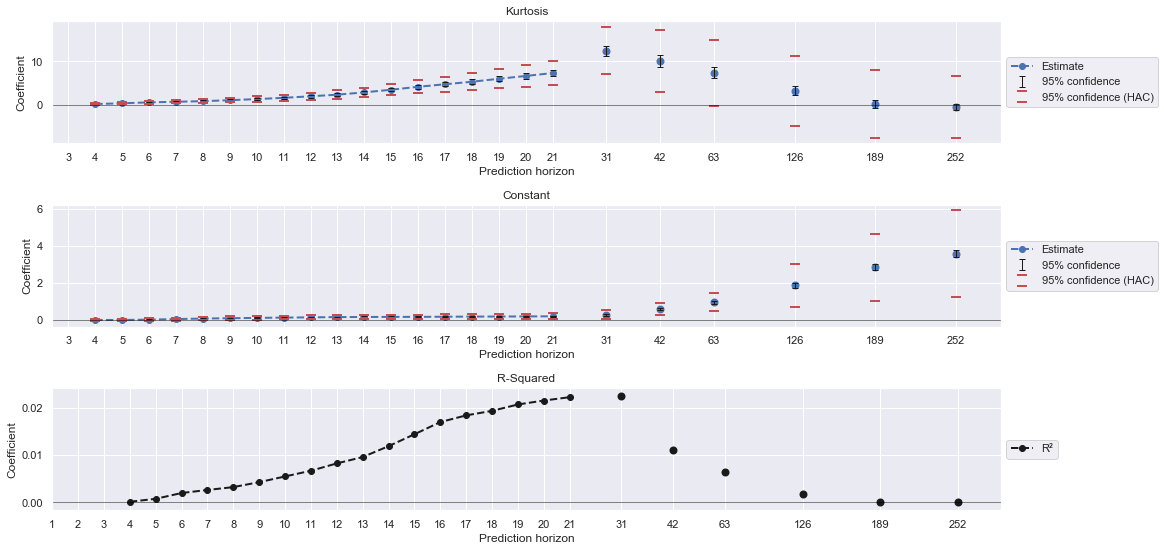

In [979]:
fig, axes = plt.subplots(3, 1, figsize=(17,9))

axes[0].plot(horizons[0:21], df_regs['mean','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].scatter([23,25,27,30,33,36], df_regs['mean','est'].values[21:], linewidth=2, marker='o')
axes[0].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[0].set_xticklabels(horizons)
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e.'].values*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['mean','est'].values, yerr=df_regs['mean','s.e. hac'].values*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_xlabel('Prediction horizon')
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Kurtosis')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[1].plot(horizons[0:21], df_regs['const','est'].values[0:21], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].scatter([23,25,27,30,33,36], df_regs['const','est'].values[21:], linewidth=2, marker='o')
axes[1].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[1].set_xticklabels(horizons)
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e.'].values*1.96, 
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(horizons[0:21].tolist()+[23,25,27,30,33,36], df_regs['const','est'].values, yerr=df_regs['const','s.e. hac'].values*1.96, 
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (HAC)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_xlabel('Prediction horizon')
axes[1].set_ylabel('Coefficient')
axes[1].set_title('Constant')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].plot(horizons[0:21], df_regs['regression','R2'].values[0:21], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].scatter([23,25,27,30,33,36], df_regs['regression','R2'].values[21:], linewidth=2, marker='o', color='k')
axes[2].set_xticks(horizons[0:21].tolist()+[23,25,27,30,33,36])
axes[2].set_xticklabels(horizons)
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_xlabel('Prediction horizon')
axes[2].set_ylabel('Coefficient')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.5)

plt.show()